# Deep Learning for NLP - Project - Paul Asquin

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy

In [2]:
PATH_TO_DATA = "data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        
        # Patching id2word
        for i, key in enumerate(self.word2vec.keys()):
            self.word2id[key]=i    
        self.id2word = {v: k for k, v in self.word2id.items()}
        
        # Computing scores
        scores = []
        for dic_word in self.word2vec:
            scores.append(self.score(w, dic_word))
            
        # Extracting the K best ids (K last with sorted list)
        id_K_most_similar = np.argsort(scores)[::-1][0:K]
    
        # Getting their names
        word_K_most_similar = []
        for id_word in id_K_most_similar:
            word_K_most_similar.append(self.id2word[id_word])

        return word_K_most_similar
        
    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        if w1 in self.word2vec.keys() and w2 in self.word2vec.keys():
            w1_emb = self.word2vec[w1]
            w2_emb = self.word2vec[w2]
            return np.dot(w1_emb, w2_emb) / (np.linalg.norm(w1_emb) * np.linalg.norm(w2_emb))
        else:
            return 0

In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=30000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))
    
# NOTE : On teacher's adive, used nmax = 30000 to obtain coherent results for paris, france, germany and berlin

Loaded 30000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0
['cat', 'cats', 'kitty', 'kitten', 'feline']
['dog', 'dogs', 'puppy', 'Dog', 'canine']
['dogs', 'dog', 'Dogs', 'puppies', 'cats']
['paris', 'france', 'Paris', 'london', 'europe']
['germany', 'europe', 'german', 'france', 'Germany']


In [4]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
            if idf is False:
                # mean of word vectors 
                embeddings = []
                for word in sent:
                    if word in self.w2v.word2vec:
                        embeddings.append(self.w2v.word2vec[word])
                if len(embeddings) == 0:
                    sentemb.append(np.zeros(list(self.w2v.word2vec.values())[0].shape))
                else:
                    sentemb.append(np.mean(embeddings, axis=0))
            else:
                # idf-weighted mean of word vectors
                embeddings = []
                for word in sent:
                    if word in self.w2v.word2vec:
                        embeddings.append(idf[word] * self.w2v.word2vec[word])
                if len(embeddings) == 0:
                    sentemb.append(np.zeros(list(self.w2v.word2vec.values())[0].shape))
                else:
                    sentemb.append(np.mean(embeddings, axis=0))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        
        scores = []
        similar_sentences = []
        # Computing scores
        for id_sentence in sentences:
            scores.append(self.score(s, id_sentence, idf))
        
        # Extracting the K best ids (K last with sorted list)
        id_K_most_similar = (np.argsort(scores)[::-1][0:K])
    
        # Getting the sentences
        for id_similar_sentence in id_K_most_similar:
            similar_sentences.append(sentences[id_similar_sentence])
        print("\nSimilar sentences to ", " ".join(s), " :") 
        print("\n".join([" ".join(sentence) for sentence in similar_sentences]))
        return similar_sentences

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        s1_emb = self.encode([s1], idf)
        s2_emb = self.encode([s2], idf)
        if np.linalg.norm(s1_emb) != 0 and np.linalg.norm(s2_emb)!=0:
            return np.dot(s1_emb, s2_emb.T) / (np.linalg.norm(s1_emb) * np.linalg.norm(s2_emb))
        else:
            return 0
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1
        for word in idf:
            idf[word] = max(1, np.log10(len(sentences) / (idf[word])))
        return idf


In [7]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
with open(os.path.join(PATH_TO_DATA,'sentences.txt')) as file_sentences:
    for line in file_sentences:
        sentences.append(line.replace(" \n", "").replace("\n", "").split(" "))

# Build idf scores for each word
#idf = {} if True else s2v.build_idf(sentences)
idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13])


# idf = {}  
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf)

Loaded 5000 pretrained word vectors

Similar sentences to  1 smiling african american boy .  :
1 smiling african american boy .
blond boy waterskiing .
a boy jumps .
a boy jumps .
a boy smiles underwater .

Similar sentences to  1 smiling african american boy .  :
1 smiling african american boy .
5 women and 1 man are smiling for the camera .
a man rides a 4 wheeler in the desert .
3 males and 1 woman enjoying a sporting event
a man in black is juggling 3 flamed bottles .


array([[0.59633357]])

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

print("Loading English")
word2vec_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)
print("Loading French")
word2vec_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)

# Patching id2word
for i, key in enumerate(word2vec_fr.word2vec.keys()):
    word2vec_fr.word2id[key]=i    
word2vec_fr.id2word = {v: k for k, v in word2vec_fr.word2id.items()}

for i, key in enumerate(word2vec_en.word2vec.keys()):
    word2vec_en.word2id[key]=i    
word2vec_en.id2word = {v: k for k, v in word2vec_en.word2id.items()}


Loading English
Loaded 50000 pretrained word vectors
Loading French
Loaded 50000 pretrained word vectors


In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

shared_words = []
for word in word2vec_en.word2vec:
    if word in word2vec_fr.word2vec:
        shared_words.append(word)

print("# shared words", len(shared_words))

X = []
Y = []
for word in shared_words:
    X.append(word2vec_en.word2vec[word])
    Y.append(word2vec_fr.word2vec[word])
  
X = np.array(X).T
Y = np.array(Y).T

print("X shape : ", X.shape)
print("Y shape : ", X.shape)

# shared words 18970
X shape :  (300, 18970)
Y shape :  (300, 18970)


In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

from scipy import linalg
U, S, V = linalg.svd(np.dot(Y, X.T))
W = np.dot(U, V)
word2vec_fr_trans = np.dot(list(word2vec_fr.word2vec.values()), W)

id2word_fr_trans = dict()
id2word_fr_list = list(word2vec_fr.word2vec)

for id_word in range(len(word2vec_fr_trans)):
    id2word_fr_trans[id2word_fr_list[id_word]] = word2vec_fr_trans[id_word]

print("U shape", U.shape)
print("W shape", W.shape)
print("word2vec_fr_trans shape", word2vec_fr_trans.shape)

U shape (300, 300)
W shape (300, 300)
word2vec_fr_trans shape (50000, 300)


In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

def score(word_vec, word_vec_candidate):
    return np.dot(word_vec, word_vec_candidate)/(np.linalg.norm(word_vec)*np.linalg.norm(word_vec_candidate))

def trans_fr2en(word_to_trans, K = 5):
    if word_to_trans not in id2word_fr_trans:
        raise ValueError("Word not in dic")
    
    # Get scores
    scores = {}
    for word in word2vec_en.word2vec:
        word_vec = id2word_fr_trans[word_to_trans]
        word_vec_candidate = word2vec_en.word2vec[word]
        scores[word] = score(word_vec, word_vec_candidate)
    return sorted(scores, key=scores.get)[::-1][0:K]

fr = ["souris", "chat", "chien", "voiture", "maison"]
for word in fr:
    print(word, ":", trans_fr2en(word))

        
def trans_en2fr(word_to_trans, K = 5):
    if word_to_trans not in word2vec_en.word2vec:
        raise ValueError("Word not in dic")
    
    # Get scores
    scores = {}
    for word in id2word_fr_trans:
        word_vec = word2vec_en.word2vec[word_to_trans]
        word_vec_candidate = np.array(id2word_fr_trans[word])
        scores[word] = score(word_vec, word_vec_candidate)
    return sorted(scores, key=scores.get)[::-1][0:K]

print(" --- ")

fr = ["elephant", "bed", "kitchen", "mountain", "cat"]
for word in fr:
    print(word, ":", trans_en2fr(word))



souris : ['mouse', 'mice', 'rats', 'rodents', 'raccoons']
chat : ['cat', 'rabbit', 'hamster', 'feline', 'poodle']
chien : ['dog', 'poodle', 'terrier', 'dogs', 'spaniel']
voiture : ['car', 'cars', 'limousine', 'suv', 'roadster']
maison : ['house', 'maison', 'townhouse', 'hôtel', 'mansion']
 --- 
elephant : ['éléphant', 'elephant', 'éléphants', 'rhinocéros', 'panthère']
bed : ['lit', 'matelas', 'lits', 'baignoire', 'sleeping']
kitchen : ['cuisines', 'cuisine', 'room', 'kitchen', 'cuisiner']
mountain : ['mountain', 'montagne', 'mountains', 'peak', 'montagneuse']
cat : ['cat', 'chat', 'dog', 'chats', 'chien']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [8]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
path_train = os.path.join(PATH_TO_DATA,'SST','stsa.fine.train')
path_dev = os.path.join(PATH_TO_DATA,'SST','stsa.fine.dev')
path_test = os.path.join(PATH_TO_DATA,'SST','stsa.fine.test.X')

def read_training(file_path):
    with open(file_path,'r') as file:
        x = []
        y = []
        for line in file:
            x.append(line[2:].split())
            y.append(int(line[0])) 
    return x, y

def read_test(file_path):
    x = []
    with open(file_path,'r') as file:
        for line in file:
            x.append(line.split())
    return x

x_train, y_train = read_training(path_train)
x_dev, y_dev = read_training(path_dev)
x_test = read_test(path_test)

In [9]:
# 2 - Encode sentences with the BoV model above

idf = s2v.build_idf(x_train + x_dev + x_test)

# Init vocabularies
word2vec_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)
sentence2vec = BoV(w2v)

# Encode vectors
x_train_enc = sentence2vec.encode(x_train)
x_dev_enc = sentence2vec.encode(x_dev)
x_test_enc = sentence2vec.encode(x_test)
x_train_enc_idf = s2v.encode(x_train,idf)
x_dev_enc_idf = s2v.encode(x_dev,idf)


Loaded 50000 pretrained word vectors


In [14]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

import sklearn.linear_model as linear_model
import sklearn.metrics as metrics

lr = linear_model.LogisticRegression(C= 0.9, max_iter=5000, tol=1e-9, solver='lbfgs', multi_class='auto')
lr.fit(x_train_enc,y_train)
pred_dev = lr.predict(x_dev_enc)
pred_train = lr.predict(x_train_enc)

print("Train set accuracy ", metrics.accuracy_score(y_train, pred_train))
print("Dev   set accuracy ", metrics.accuracy_score(y_dev, pred_dev))

lr_idf = linear_model.LogisticRegression(C= 0.9, max_iter=5000, tol=1e-9, solver='lbfgs', multi_class='auto')
lr_idf.fit(x_train_enc_idf,y_train)
pred_dev_idf = lr_idf.predict(x_dev_enc_idf)
pred_train_idf = lr_idf.predict(x_train_enc_idf)
                                
print("IDF - Train set accuracy ", metrics.accuracy_score(y_train, pred_train_idf))
print("IDF - Dev   set accuracy ", metrics.accuracy_score(y_dev, pred_dev_idf))

Train set accuracy  0.43316947565543074
Dev   set accuracy  0.3751135331516803
IDF - Train set accuracy  0.43972378277153557
IDF - Dev   set accuracy  0.36693914623069934


In [14]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# Generating prediction for test vector
pred_test = lr.predict(x_test_enc)

# Writting the results
with open("logreg_bov_y_test_sst.txt",'w') as file:
    for line in pred_test:
        file.write(str(line) + "\n")

In [15]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [16]:
import keras

Using TensorFlow backend.


In [17]:
# 1 - Load train/dev/test sets of SST
# PATH_TO_DATA = "../../data/"

path_train2 = os.path.join(PATH_TO_DATA,'SST','stsa.fine.train')
path_dev2 = os.path.join(PATH_TO_DATA,'SST','stsa.fine.dev')
path_test2 = os.path.join(PATH_TO_DATA,'SST','stsa.fine.test.X')

x_train2, y_train2 = read_training(path_train2)
x_dev2, y_dev2 = read_training(path_dev2)
x_test2 = read_test(path_test2)

In [18]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

import keras.preprocessing as preprocessing
import keras.utils as utils

words = []
for sentence in x_train + x_dev + x_test:
    for word in sentence:
        if word not in words:
            words.append(word)

x_train2_one_hot = []
x_dev2_one_hot = []
x_test2_one_hot = []

for x in x_train:
    x_train2_one_hot.append(preprocessing.text.one_hot(" ".join(x), len(words)))

for x in x_dev2:
    x_dev2_one_hot.append(preprocessing.text.one_hot(" ".join(x), len(words)))
    
for x in x_test2:
    x_test2_one_hot.append(preprocessing.text.one_hot(" ".join(x), len(words)))    

y_train2 = utils.to_categorical(y_train2)
y_dev2 = utils.to_categorical(y_dev2)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [19]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

import keras.preprocessing.sequence as sequence

x_train2_pad = sequence.pad_sequences(x_train2_one_hot)
x_dev2_pad = sequence.pad_sequences(x_dev2_one_hot)
x_test2_pad = sequence.pad_sequences(x_test2_one_hot)


## 4.2 - Design and train your model

In [20]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 64  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = len(words)  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2))
model.add(Dense(n_classes, activation='softmax'))


/home/paul/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.2, recurrent_dropout=0.2)`
  app.launch_new_instance()


In [21]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          1250304   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 1,283,653
Trainable params: 1,283,653
Non-trainable params: 0
_________________________________________________________________
None


/home/paul/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if sys.path[0] == '':


Train on 8544 samples, validate on 1101 samples
Epoch 1/7
8544/8544 [==============================] - 11s 1ms/step - loss: 1.5670 - acc: 0.2831 - val_loss: 1.5225 - val_acc: 0.3052
Epoch 2/7
8544/8544 [==============================] - 11s 1ms/step - loss: 1.3598 - acc: 0.4185 - val_loss: 1.3622 - val_acc: 0.4069
Epoch 3/7
8544/8544 [==============================] - 11s 1ms/step - loss: 1.0509 - acc: 0.5756 - val_loss: 1.4259 - val_acc: 0.3924
Epoch 4/7
8544/8544 [==============================] - 11s 1ms/step - loss: 0.7861 - acc: 0.6999 - val_loss: 1.6248 - val_acc: 0.3860
Epoch 5/7
8544/8544 [==============================] - 15s 2ms/step - loss: 0.5770 - acc: 0.7941 - val_loss: 1.8815 - val_acc: 0.3851
Epoch 6/7
8544/8544 [==============================] - 15s 2ms/step - loss: 0.4277 - acc: 0.8524 - val_loss: 2.1534 - val_acc: 0.3688
Epoch 7/7
8544/8544 [==============================] - 14s 2ms/step - loss: 0.3300 - acc: 0.8853 - val_loss: 2.3840 - val_acc: 0.3769


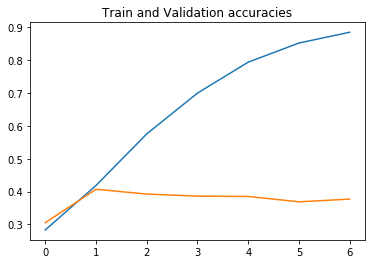

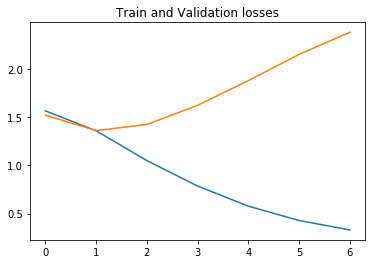

In [22]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import ModelCheckpoint

bs = 64
n_epochs = 7

history = model.fit(x_train2_pad, y_train2, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_dev2_pad, y_dev2))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Train and Validation accuracies")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Train and Validation losses")
plt.show()

# NOTE : model training are too stressfull operations for my computer which is smelling like burnt electric cables...
# even if I would enjoy to better fit the model and improve my results, I can't afford to break my computer
# as it already happened to me before. I hope you will understand my concerns.

In [23]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

model_pred = model.predict(x_test2_pad, batch_size=bs).argmax(axis=-1)
model_pred.tofile('logreg_lstm_y_test_sst.txt', sep="\n")

## 4.3 -- innovate !

In [24]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
